In [ ]:
#retrieve data from raw file
!wget https://raw.githubusercontent.com/tasdikrahman/datasets/master/email/csv/spam-apache.csv

--2022-10-27 01:53:53--  https://raw.githubusercontent.com/tasdikrahman/datasets/master/email/csv/spam-apache.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 366506 (358K) [text/plain]
Saving to: ‘spam-apache.csv.10’

spam-apache.csv.10  100%[===================>] 357.92K  --.-KB/s    in 0.02s   

2022-10-27 01:53:53 (14.6 MB/s) - ‘spam-apache.csv.10’ saved [366506/366506]






Dictionaries python ?
Table queries python ?
DO NOT HARD CODE PROCESSED WORDS; 

In [ ]:
import numpy as np
import pandas as pd


#load data
pd_data = pd.read_csv("spam-apache.csv",header=None)
#shuffle data
pd_data = pd_data.sample(frac=1)
#put data to array
test = pd_data.to_numpy()

#print(pd_data.head().to_numpy())
#np.shape(pd_data.head().to_numpy())
#len(pd_data.to_numpy())


Citations for start() function:

[1] [Calculating confusion matrix values](https://kawahara.ca/how-to-compute-truefalse-positives-and-truefalse-negatives-in-python-for-binary-classification-problems/)

In [ ]:
def start(split):
  #use split value to declare training / testing sets
  training_set = test[:int((len(test) * split)),:]
  testing_set = test[:int(len(test) * (1-split)),:]

  print("Length of training set: ",len(training_set))
  print("Length of tesitng set: ",len(testing_set))

  #separate spam / ham emails from training set
  training_spam_emails = training_set[training_set[:,0] == -1, 1]
  training_ham_emails = training_set[training_set[:,0] == 1,1]

  # separate spam / ham emails from testing set
  testing_spam_emails = testing_set[testing_set[:,0] == -1, 1]
  testing_ham_emails = testing_set[testing_set[:,0] == 1,1]

  #bias
  bias = np.log(len(training_spam_emails) / len(training_ham_emails))

  #LEARN DATA
  #retrieve processed words
  processed_words = learn_Data(training_spam_emails,training_ham_emails)
  


  #create separate lists of testing emails and labels
  testing_total_emails = testing_set[:,1]
  testing_total_labels = testing_set[:,0]

  #true labels
  actual = testing_total_labels
  #predicted labels; TEST DATA
  predicted = np.empty(len(testing_set),dtype='object')
  for i in range(len(testing_set)):
    predicted[i] = classify(clean(testing_total_emails[i]).split(), processed_words, bias)

  
  #calculate values for confusion matrix    [1]
  TP = np.sum(np.logical_and(predicted == 1, actual == 1))
  TN = np.sum(np.logical_and(predicted == -1, actual == -1))
  FP = np.sum(np.logical_and(predicted == 1, actual == -1))
  FN = np.sum(np.logical_and(predicted == -1, actual == 1))
  total_values = len(testing_set)
  #calculate accuracy
  accuracy = (TP+TN) / total_values
  print("Values: \nTP: %s\tTN: %s\tFP: %s\tFN: %s\t"%(TP,TN,FP,FN))
  print("Accuracy: %.2f"%(accuracy))
  print("Percentages: \nTP: %.2f\tTN: %.2f\tFP: %.2f\tFN: %.2f\t"%(TP/total_values,TN/total_values,FP/total_values,FN/total_values))

  #create_confusion_matrix(actual,predicted)
  return accuracy,len(training_set)




In [ ]:
def learn_Data(training_ham, training_spam):

  #join all emails (spam & ham separately) into two big strings; [2]
  #clean the two strings; split strings into two arrays of words
  words_spam = clean(' '.join(training_spam)).split()
  words_ham = clean(' '.join(training_ham)).split()

  #get the count of all words from training emails
  total_words_count = len(words_spam) + len(words_ham)


  #find common words in words_spam & words_ham      [3]
  #create array of spam words w/o duplicates
  words_set_spam = set(words_spam)
  #create array of ham words w/o duplicates
  words_set_ham = set(words_ham)
  #create list of words that are found in both word lists
  shared = words_set_spam.intersection(words_set_ham)

  #create dictionary of words with key:value pairs; key = word; value = [(probability of word in spam), (probability of word in ham)]
  prop_of_words = {}
  #populate dictionary
  for word in shared:
    #number of occurences current word is found in both 
    word_count_both = words_spam.count(word) + words_ham.count(word)
    #divide count of spam/ham word by total occurence of word in both lists; save values to dictionary
    prop_of_words[word] = [words_spam.count(word)/word_count_both, words_ham.count(word)/word_count_both]

  prop_of_words

  #return dictionary
  return prop_of_words

Citations for learn_Data() function:

[2] [Joining strings in a list](https://www.simplilearn.com/tutorials/python-tutorial/list-to-string-in-python#:~:text=To%20convert%20a%20list%20to%20a%20string%2C%20use%20Python%20List,and%20return%20it%20as%20output.)

[3] Concept of using sets to find common words:
- [Finding Common words in a list](https://stackoverflow.com/questions/18264471/in-python-how-do-i-find-common-words-from-two-lists-while-preserving-word-order)
- [Set Intersection](https://www.programiz.com/python-programming/methods/set/intersection)


In [ ]:
#function that "cleans" email data by removing html tags and set words in data to lowercase

import re
import string

def clean(x):
  #remove html tags and converts string to lowercase  [4]
  newStr = re.sub(r'<[^>]*>',' ',x).lower()
  #remove punctuation
  newStr = re.sub(r'[^\w\s]','',newStr)  #newStr.translate(str.maketrans('','',string.punctuation))
  return newStr

  
#for i in range(6):
  #spam_emails[i] = clean(spam_emails[i])
  #print(spam_emails[i])




Citations for clean() method:

[4] [Removing HTML tags from string](https://stackoverflow.com/questions/11229831/regular-expression-to-remove-html-tags-from-a-string)

In [ ]:
def classify(text,processed,bias):
  #grab only words from text that have been trained
  observed_words = [word for word in text if word in processed]

  #sum of the all logs of probabilites initiated at the bias    [5]
  final = sum(np.log(processed[word][0] / processed[word][1]) for word in observed_words) + bias

  #print(final)
  
  #if final < 0: classify as spam; else: classify as ham
  if(final < 0):
    return -1
  else:
    return 1

Citations for classify() method:

[5] Understanding list comprehension and doing arithmetic in list comprehension
- [Arithmetic Operations in a list](https://stackoverflow.com/questions/32946714/arithmetic-operations-in-a-list)

Length of training set:  200
Length of tesitng set:  49
Values: 
TP: 17	TN: 28	FP: 0	FN: 4	
Accuracy: 0.92
Percentages: 
TP: 0.35	TN: 0.57	FP: 0.00	FN: 0.08	


Length of training set:  175
Length of tesitng set:  75
Values: 
TP: 18	TN: 40	FP: 0	FN: 17	
Accuracy: 0.77
Percentages: 
TP: 0.24	TN: 0.53	FP: 0.00	FN: 0.23	


Length of training set:  100
Length of tesitng set:  150
Values: 
TP: 12	TN: 80	FP: 1	FN: 57	
Accuracy: 0.61
Percentages: 
TP: 0.08	TN: 0.53	FP: 0.01	FN: 0.38	




Text(0, 0.5, 'Accuracy (Percentage)')

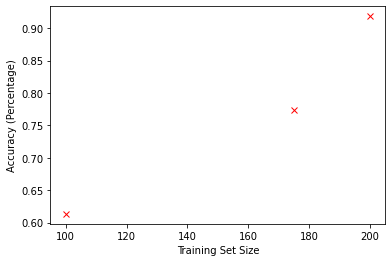

In [ ]:
#RESULTS

#start program with 80(training)/20(testing) split
filter1 = start(.8)
print("\n")
#start program with 70/30 split
filter2 = start(.7)
print("\n")
#start program with 40/60 split
filter3 = start(.4)
print("\n")

import matplotlib.pyplot as plt

#create accuracy chart
x_training_size = [filter1[1],filter2[1],filter3[1]]
y_accuracies = [filter1[0],filter2[0],filter3[0]]

plt.plot(x_training_size,y_accuracies, 'rx')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy (Percentage)')





In [ ]:
#create array of labels that diff spam vs. ham emails
labels = test[:,0]
  #print(labels)

#create array of emails
emails = test[:,1]
  #print(emails[0])

In [ ]:
#shuffle data


#declare training set to train the model

#grab first 200 points of data as training set
training_set = test[:200,:] 
#set remaining for testing set
testing_set = test[200:,:]

# separate spam / ham emails from training set
training_spam_emails = training_set[training_set[:,0] == -1, 1]
training_ham_emails = training_set[training_set[:,0] == 1,1]

# separate spam / ham emails from testing set
testing_spam_emails = testing_set[testing_set[:,0] == -1, 1]
testing_ham_emails = testing_set[testing_set[:,0] == 1,1]


In [ ]:
#clean data

#join all emails (spam & ham separately) into two big strings; clean the two strings; split strings into two arrays of words
words_spam = clean(' '.join(training_spam_emails)).split()
words_ham = clean(' '.join(training_ham_emails)).split()

total_words_count = len(words_spam) + len(words_ham)


#print(words_spam)
#len(words_spam)
#total_words_count
    

In [ ]:
#find common words in words_spam & words_ham

#create array of spam words w/o duplicates
words_set_spam = set(words_spam)
#create array of ham words w/o duplicates
words_set_ham = set(words_ham)
#create list of words that are found in both word lists
shared = words_set_spam.intersection(words_set_ham)

#len(words_set_spam)

In [ ]:
#create dictionary of words with key:value pairs; key = word; value = [(frequency of word in spam), (frequency of word in ham)]
prop_of_words = {}
#populate dictionary
for word in shared:
  word_count = words_spam.count(word)
  prop_of_words[word] = [words_spam.count(word), words_ham.count(word)]
  s = words_spam.count(word) + words_ham.count(word)
  prop_of_words[word][0] /= s
  prop_of_words[word][1] /= s

  
prop_of_words
  

{'weeks': [0.7777777777777778, 0.2222222222222222],
 'visit': [0.9090909090909091, 0.09090909090909091],
 'closer': [0.5, 0.5],
 'breasts': [0.6666666666666666, 0.3333333333333333],
 'worlds': [0.6666666666666666, 0.3333333333333333],
 'manual': [0.6666666666666666, 0.3333333333333333],
 'electronic': [0.5, 0.5],
 'coverage': [0.5, 0.5],
 'exercise': [0.8333333333333334, 0.16666666666666666],
 'do': [0.6792452830188679, 0.32075471698113206],
 'engineer': [0.125, 0.875],
 'writing': [0.6666666666666666, 0.3333333333333333],
 'terrible': [0.5, 0.5],
 'own': [0.6521739130434783, 0.34782608695652173],
 'unit': [0.3333333333333333, 0.6666666666666666],
 'selling': [0.5, 0.5],
 'consultant': [0.5, 0.5],
 'package': [0.25, 0.75],
 'id': [0.09090909090909091, 0.9090909090909091],
 'but': [0.2789115646258503, 0.7210884353741497],
 'our': [0.8848920863309353, 0.11510791366906475],
 'where': [0.7027027027027027, 0.2972972972972973],
 'sorts': [0.5, 0.5],
 'applicants': [0.5, 0.5],
 'a': [0.443661

In [ ]:
#bias
bias = np.log(len(training_spam_emails) / len(training_ham_emails))

In [ ]:
def classify(text):
  #grab only words from text that have been trained
  observed_words = [word for word in text if word in prop_of_words]

  #sum of the all logs of probabilites initiated at the bias
  final = sum(np.log(prop_of_words[word][1] / prop_of_words[word][0]) for word in observed_words) + bias

  #print(final)
  
  #if final < 0: classify as spam; else: classify as ham
  if(final < 0):
    return -1
  else:
    return 1
 

In [ ]:
np.log(.2/.8)

-1.3862943611198906

In [ ]:
#classify testing data
testing_total_emails = testing_set[:,1]
testing_total_labels = testing_set[:,0]

#true labels
actual = testing_total_labels
#predicted labels;
predicted = np.empty(len(testing_set),dtype='object')
for i in range(len(testing_set)):
  predicted[i] = classify(clean(testing_total_emails[i]).split())


#print(predicted)
#print(actual)

#calculate values for confusion matrix
TP = np.sum(np.logical_and(predicted == 1, actual == 1))
TN = np.sum(np.logical_and(predicted == -1, actual == -1))
FP = np.sum(np.logical_and(predicted == 1, actual == -1))
FN = np.sum(np.logical_and(predicted == -1, actual == 1))
total_values = len(testing_set)
accuracy = (TP+TN) / total_values
print("Values: \nTP: %s\tTN: %s\tFP: %s\tFN: %s\t"%(TP,TN,FP,FN))
print("Accuracy: %s"%(accuracy))
print("Percentages: \nTP: %s\tTN: %s\tFP: %s\tFN: %s\t"%(TP/total_values,TN/total_values,FP/total_values,FN/total_values))

Values: 
TP: 7	TN: 24	FP: 0	FN: 19	
Accuracy: 0.62
Percentages: 
TP: 0.14	TN: 0.48	FP: 0.0	FN: 0.38	


In [ ]:
print(predicted)
print(actual)

[1 1 1 1 -1 -1 1 -1 -1 1 -1 -1 1 -1 1 -1 1 1 -1 1 1 1 1 -1 -1 -1 1 1 -1 1
 1 -1 1 1 1 -1 1 -1 -1 1 1 1 1 1 1 1 1 1 -1 -1]
[-1 -1 -1 1 1 1 -1 1 1 -1 1 1 -1 1 1 1 -1 -1 1 -1 -1 -1 -1 1 1 1 -1 -1 1 1
 1 1 -1 -1 -1 1 1 1 1 -1 1 -1 -1 -1 -1 -1 -1 -1 1 -1]


In [ ]:
accuracy_matrix = np.zeros(np.shape(testing_set))
for i in range (len(testing_set)):
  predicted = classify(clean(testing_total_emails[i]).split())
  accuracy_matrix[i][0] = predicted
  for j in range (len(testing_set)):
    actual = testing_total_labels[j]
    accuracy_matrix[j][1] = actual


probability of (x) =  # of word occurences in (x) / # all words in (x)